# Part 4: Convexity and Constrained Optimization

In [1]:
import importlib

import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import useful_functions
importlib.reload(useful_functions)
from useful_functions import generate_dataset, unison_shuffled_copies, get_train_test_datasets, gradient_descent, plot_convergence_rate
from useful_functions import plot_evolution_on_test_error, plot_evolution_on_test_error_with_bias, plot_iterates_l2_2D, plot_iterates_l1_2D


## Question 1: implement the conditional gradient algorithm and the projected gradient algorithm on l-2 ball

### Generate dataset

We will test our various implentation on a toy dataset composed of 200 samples and 2 features, that is generated using a linear relation: 
$$ y = 4x_{1} + 3x_{2} + \epsilon $$

where $\epsilon$ is gaussan noise.

In [2]:
nsamples = 200
sigma = 0.4
range_uniform=5
xtrain, ytrain = generate_dataset(nsamples,range_uniform, sigma)
xtest, ytest = generate_dataset(nsamples,range_uniform, sigma)

### Projected Gradient

In [3]:
#GD implementation to project on the l2-ball
n_epochs = 200
step_size = 1e-5
R = 3 #parameter for size of the ball
norm = 2

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=2),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)

    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    x_proj = x_proj - step_size * gradients_proj
    x_proj = (R/max(np.linalg.norm(x,ord=norm),R))*x #projection on l2 ball
    X_proj[:,epoch] = x_proj

Below we show our reults of PGD on l2-ball of parameter $R=3$ 
What we can as at the beggining, the beahviour is similar to the one of GD. But when we hit the constraint PGD isn't able to goes forward and stays on the limit (the black circle). As the optimal parameter (3,4) is outside the circle the GD can converges to the best results. 

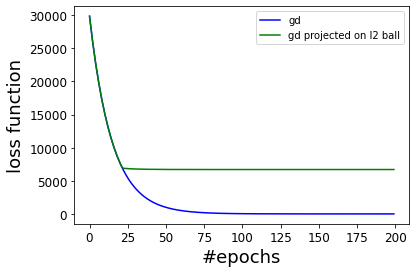

In [4]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l2 ball')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

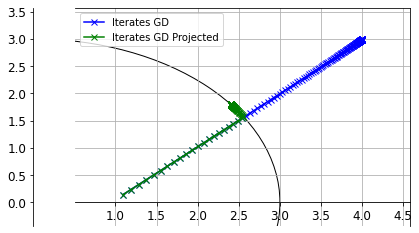

In [5]:
plot_iterates_l2_2D(X, X_proj, R, with_set=True)

For $R=5$, the PGD and GD have same behaviour as the constraint don't play any role.

In [21]:
#GD implementation to project on the l2-ball
n_epochs = 200
step_size = 1e-5
R = 5 #parameter for size of the ball
norm = 2

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=2),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)

    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    x_proj = x_proj - step_size * gradients_proj
    x_proj = (R/max(np.linalg.norm(x,ord=norm),R))*x #projection on l2 ball
    X_proj[:,epoch] = x_proj

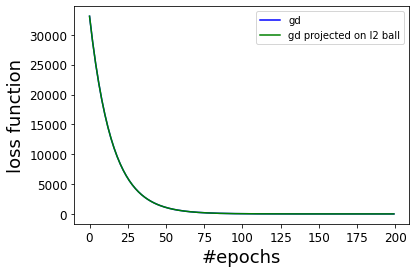

In [22]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l2 ball')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

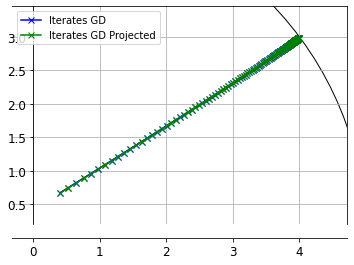

In [23]:
plot_iterates_l2_2D(X, X_proj, R, with_set=True)

### Conditional Gradient

In [6]:
def extreme_point_argmin(D, gradient, norm, R):
    '''
    Calculate the argmin from subproblem in Frank-Wolfe algorihtm
    '''
    q_ = 1/(1-1/norm)  #for ensuring Holder inequality
    s = np.zeros(D)
    a = 0
    for d in range(D):
         a = a + np.abs(gradient[d])**q_
    a = a**(1/norm)
    for d in range(D):
        s[d] = -R*np.sign(gradient[d])*np.abs(gradient[d])**(q_-1)/a

    return s 

In [17]:
#Conditional gradient implementation on l2-ball
n_epochs = 200
step_size = 1e-5
R = 5 #parameter for size of the ball
norm = 2

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=2),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)
    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    step_size_fw = 2/(2+epoch)
    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    s = extreme_point_argmin(D, gradients_proj, norm, R)
    x_proj = step_size_fw*s + (1-step_size_fw)*x_proj
    X_proj[:,epoch] = x_proj

With conditional gradient descent, the main difference with PGD is the decaying step size. At the begginning, the behaviour seems erratic but as the step size shrinks we get results that converges towards PGD. However, because of step size the speed of convergence is faster for conditional gradient vs PGD or GD. 
Let's not that if the optimal parameter was inside the constraint, the PGD , GD and Conditional Gradient would converge towards the same value. 

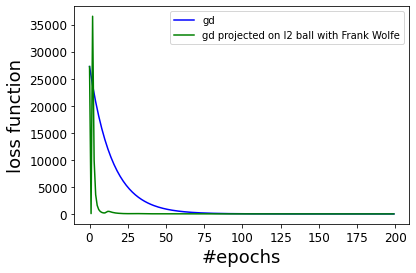

In [18]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l2 ball with Frank Wolfe')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

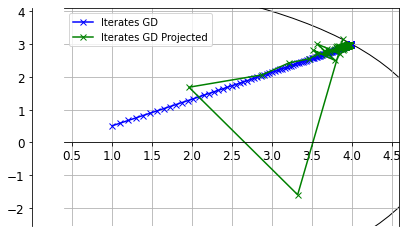

In [19]:
plot_iterates_l2_2D(X, X_proj, R, with_set=True)

## Question 2: implement the conditional gradient algorithm and the projected gradient algorithm on l-1 ball

When instead of projecting on the l2 ball we project on the l1 ball, the behaviour of various algorithms doesn't change that much (execpt for the shape of the constraint).
The constraint plays a role only for small $R$ and the conditional gradient converges faster. 

### Projected Gradient

In [10]:
#GD implementation to project on the l2-ball
n_epochs = 200
step_size = 1e-5
R = 3 #parameter for size of the ball
norm = 1

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=1),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)

    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    x_proj = x_proj - step_size * gradients_proj
    x_proj = (R/max(np.linalg.norm(x,ord=norm),R))*x #projection on l1 ball
    X_proj[:,epoch] = x_proj

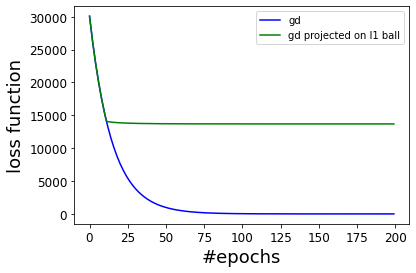

In [11]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l1 ball')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

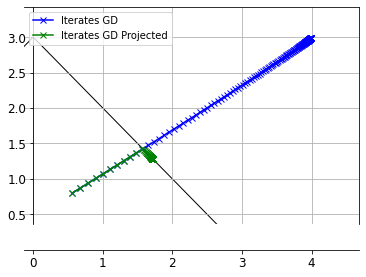

In [12]:
plot_iterates_l1_2D(X, X_proj, R, with_set=True)

### Conditional Gradient 

In [13]:
def extreme_point_argmin(D, gradient, norm, R):
    '''
    Calculate the argmin from subproblem in Frank-Wolfe algorihtm
    '''

    if norm >=2:
        q_ = 1/(1-1/norm)  #for ensuring Holder inequality
        s = np.zeros(D)
        a = 0
        for d in range(D):
            a = a + np.abs(gradient[d])**q_
        a = a**(1/norm)
        for d in range(D):
            s[d] = -R*np.sign(gradient[d])*np.abs(gradient[d])**(q_-1)/a

        return s 
        
    elif norm == 1:
        s = np.zeros(D)
        k0 = np.argmax(np.abs(gradient))
        s[k0]=R
        s = -np.sign(gradient[k0])*s
        return s

In [14]:
#Conditional gradient implementation on l2-ball
n_epochs = 200
step_size = 1e-5
R = 5 #parameter for size of the ball
norm = 1

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=1),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)
    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    step_size_fw = 2/(2+epoch)
    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    s = extreme_point_argmin(D, gradients_proj, norm, R)
    x_proj = step_size_fw*s + (1-step_size_fw)*x_proj
    X_proj[:,epoch] = x_proj

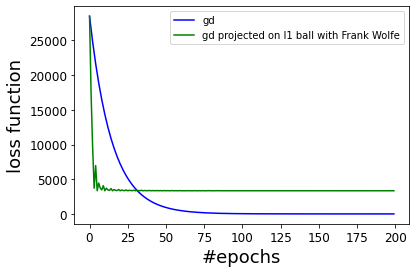

In [15]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l1 ball with Frank Wolfe')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

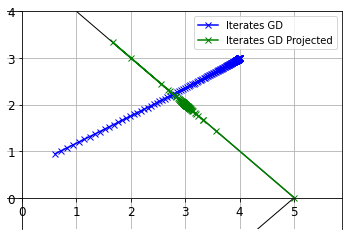

In [16]:
plot_iterates_l1_2D(X, X_proj, R, with_set=True)